# 24classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
np.random.seed(1337)
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/colab/keras/brain_tumor_dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/content/drive/MyDrive/colab/keras/brain_tumor_dataset/Testing/12/C171543.097.K.chr12.2invert_pad.jpg
/content/drive/MyDrive/colab/keras/brain_tumor_dataset/Testing/12/B173432.152.K.chr12.1invert_pad.jpg
/content/drive/MyDrive/colab/keras/brain_tumor_dataset/Testing/12/161966.084.K.chr12.2invert_pad.jpg
/content/drive/MyDrive/colab/keras/brain_tumor_dataset/Testing/12/161953.025.K.chr12.2invert_pad.jpg
/content/drive/MyDrive/colab/keras/brain_tumor_dataset/Testing/12/161938.044.K.chr12.1invert_pad.jpg
/content/drive/MyDrive/colab/keras/brain_tumor_dataset/Testing/12/c172761.032.K.chr12.1invert_pad.jpg
/content/drive/MyDrive/colab/keras/brain_tumor_dataset/Testing/12/S152055.010.K.chr12.1invert_pad.jpg
/content/drive/MyDrive/colab/keras/brain_tumor_dataset/Testing/12/c172761.086.K.chr12.2invert_pad.jpg
/content/drive/MyDrive/colab/keras/brain_tumor_dataset/Testing/12/173467.162.K.chr12.1invert_pad.jpg
/content/drive/MyDrive/colab/keras/brain_tumor_dataset/Testing/12/173467.074.K.chr12.1

# Importing Libraries

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import pathlib
import cv2
from tensorflow.keras import layers
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#preparing dataset

## creating testing validation and testing sets

/content/drive/MyDrive/colab/keras/brain_tumor_dataset/Training
3626
482
Found 3626 files belonging to 24 classes.
Using 2720 files for training.
Found 3626 files belonging to 24 classes.
Using 906 files for validation.
Found 482 files belonging to 24 classes.
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '3', '4', '5', '6', '7', '8', '9', 'X', 'Y']
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '3', '4', '5', '6', '7', '8', '9', 'X', 'Y']
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '3', '4', '5', '6', '7', '8', '9', 'X', 'Y']


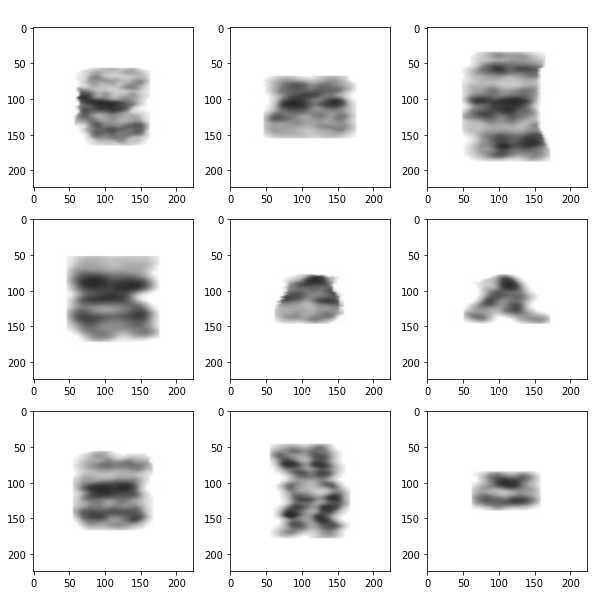

In [4]:
#path_data = '/content/drive/MyDrive/colab/keras/brain_tumor_dataset'
path_test = '/content/drive/MyDrive/colab/keras/brain_tumor_dataset/Testing'
path_data = '/content/drive/MyDrive/colab/keras/brain_tumor_dataset/Training'


path_test = pathlib.Path(path_test)
path_data = pathlib.Path(path_data)
print(path_data)

image_count = len(list(path_data.glob('*/*.jpg')))
print(image_count)
test_image_count = len(list(path_test.glob('*/*.jpg')))
print(test_image_count)

batch = 32
img_height = 224
img_width = 224
train = tf.keras.preprocessing.image_dataset_from_directory(
path_data,
validation_split = 0.25,
subset = 'training',
seed = 42,
image_size  =(img_height,img_width),
batch_size = batch)

val = tf.keras.preprocessing.image_dataset_from_directory(
path_data,
validation_split = 0.25,
subset = 'validation',
seed = 42,
image_size = (img_height,img_width),
batch_size = batch)

test = tf.keras.preprocessing.image_dataset_from_directory(
path_test,
seed = 42,
image_size = (img_height,img_width),
batch_size = batch)

print(train.class_names)
print(val.class_names)
print(test.class_names)

classes = train.class_names
plt.figure(figsize = (10,10))
for img,label in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(classes[label[i]],
                  fontdict = {'fontsize': '19',
                              'color': 'white'}
                 )
AUTOTUNE = tf.data.AUTOTUNE

train = train.prefetch(buffer_size=AUTOTUNE)
val = val.prefetch(buffer_size=AUTOTUNE)
test = test.prefetch(buffer_size=AUTOTUNE)

# Helper Functions
<a id='helper'></a>
<a id ='compare'></a>

In [5]:
def prediction_label_comparison(model,test):
    #Retrieve a batch of images from the test set
    image_batch, label_batch = test.as_numpy_iterator().next()
    prediction = model.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(prediction).numpy()

    n = 0
    predict = []
    while n<=(predictions.shape[0]-4):
        pred = np.argmax(predictions[n:n+4]) #Returns the index of the largest element in the selected subarray
        n+=4
        predict.append(pred)
    predict = np.array(predict)

    #print('Predictions:\n',predictions)#.numpy())
    print('Labels:\n', label_batch)
    print('Predictions:\n',predict)
    '''
    print(predictions.shape)
    print(label_batch.shape)
    print(predict.shape)
    '''

    plt.figure(figsize=(10, 10))
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(image_batch[i].astype("uint8"))
      plt.title(classes[predict[i]],fontdict = {'fontsize': '14',
                                  'color': 'white'})
      plt.axis("off")
    return label_batch , predict


def test_tumor(list_test_path,model):
    # sunflower_url = 'https://'
    # sunflower_path = tf.keras.utils.get_file('name of file', origin=sunflower_url)
    for path_name in list_test_path:
        test_img_path = path_name


        test_image = tf.keras.preprocessing.image.load_img(
            test_img_path, target_size=(img_height, img_width)
        )
        test_array = tf.keras.preprocessing.image.img_to_array(test_image)
        test_array = tf.expand_dims(test_array, 0) # Create a batch

        predictions = model.predict(test_array)
        score = tf.nn.softmax(predictions[0])

        print(
            "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format(classes[np.argmax(score)], 100 * np.max(score))
        )


def csv_builder(path_data,label_names):
    df = pd.DataFrame(columns = ['images','labels'])
    for name in label_names:
        BASE_DIR = str(path_data)+'/'
        #train_folder_glioma = BASE_DIR+'glioma_tumor/'
        train_folder_name = BASE_DIR+name+'/'

        #train_annotation = BASE_DIR+'annotated_train_data/'

        files_in_train = sorted(os.listdir(train_folder_name))
        #files_in_annotated = sorted(os.listdir(train_annotation))

        image_names =[i for i in files_in_train]

        
        for x in image_names:
            df = df.append({'images':train_folder_name+str(x),'labels':name},ignore_index=True)
            #df = df.append({'images':str(x),'labels':name},ignore_index=True)

        #df['images']=[train_folder_glioma+str(x) for x in image_names]
        #df['labels']=[train_annotation+str(x) for x in images]
        #pd.to_csv('files_path.csv', header=None)
    return df



def model_inputs(model2,train,val,test):
    num_classes = 24
    epochs = 15
    model2.fit(
        train,
        validation_data=val,
        epochs=epochs,
        #callbacks = callback,
        shuffle=False,
        verbose = 0
    )
    results = model2.evaluate(test)
    return results[0],results[1] , model2



def cross_validation(n_splits,final_csv,test_csv,img_width,img_height,model):
    final_loss = 0
    final_acc = 0

    '''
    Seperating a dataframe for testing data
    '''
    ##
    final_csv = final_csv.sample(frac=1)
    ##
    Y = final_csv[['labels']]
    n = len(Y)
    kf = KFold(n_splits = 5)
    #skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 
    idg = ImageDataGenerator(#width_shift_range=0.1,
#                          height_shift_range=0.1,
#                          zoom_range=0.3,
#                          fill_mode='nearest',
#                          horizontal_flip = True,
                         rescale=1./255)
    
    
    
    
    print('Performing cross validation...')
    test = idg.flow_from_dataframe(test_csv,
                                       x_col = "images",
                                       y_col = "labels",
                                       class_mode = "sparse",
                                       shuffle = True,
                                      target_size = (img_width,img_height),
                                      verbose = 0)#,subset='validation')
#     test = tf.keras.preprocessing.image_dataset_from_directory(path_test,
#                                                                    seed = 42,
#                                                                    image_size = (img_height,img_width),
#                                                                    batch_size = 32)

    for train_index, val_index in kf.split(np.zeros(n),Y):
        training_data = final_csv.iloc[train_index]
        validation_data = final_csv.iloc[val_index]
        train = idg.flow_from_dataframe(training_data,
                                        x_col = "images",
                                        y_col = "labels",
                                        class_mode = "sparse",
                                        shuffle = True,
                                        subset='training',
                                       target_size = (img_width,img_height),
                                       verbose = 0)
        val = idg.flow_from_dataframe(validation_data,
                                      x_col = "images",
                                      y_col = "labels",
                                      class_mode = "sparse",
                                      shuffle = True,
                                     target_size = (img_width,img_height),
                                     verbose = 0)	
        
#         if pretrained == 1:
#             # Create the base model from the pre-trained model MobileNet V2
#             image_size = (img_width,img_height)
#             IMG_SHAPE = image_size + (3,)
#             base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                            include_top=False,
#                                                            weights='imagenet')

#             base_model.trainable = False
#             ##
#             image_batch, label_batch = next(iter(train))
#             feature_batch = base_model(image_batch)
#             print(feature_batch.shape)
#             ##
#             global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
#             feature_batch_average = global_average_layer(feature_batch)
#             ##
#             prediction_layer = tf.keras.layers.Dense(4)
#             prediction_batch = prediction_layer(feature_batch_average)
#             ##
#             preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
#             ##
#             inputs = tf.keras.Input(shape=(250, 250, 3))
#             #x = data_augmentation(inputs)
#             x = preprocess_input(inputs)
#             x = base_model(x, training=False)
#             x = global_average_layer(x)
#             x = tf.keras.layers.Dropout(0.2)(x)
#             x = tf.keras.layers.Flatten()(x)
#             x = tf.keras.layers.Dense(1280,activation='relu')(x)
#             outputs = prediction_layer(x)
#             model = tf.keras.Model(inputs, outputs)
#             ##
#             base_learning_rate = 0.0001
#             model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
#                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                           metrics=['accuracy'])
#             ##
            
        
        '''
        Passing the preprocessed data for model training
        '''
        loss,acc,returned_model = model_inputs(model,train,val,test)
        final_loss += loss
        final_acc += acc
    return final_loss/n_splits , final_acc/n_splits , returned_model
   


normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
conv_layer_32 = tf.keras.layers.Conv2D(32,(3,3),activation='relu')
conv_layer_64 = tf.keras.layers.Conv2D(64,3,activation='relu')
conv_layer_16 = tf.keras.layers.Conv2D(16,3,activation='relu')
max_pool = tf.keras.layers.MaxPooling2D()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)


data_augmentation = tf.keras.Sequential(
  [
    normalization_layer,
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    #tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    #tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
    #tf.keras.layers.experimental.preprocessing.RandomCrop(170,170)  
  ]
)

# Model Building

# Model

In [6]:
# Create the base model from the pre-trained model MobileNet V3
num_classes = 24
image_size = (img_width,img_height)
IMG_SHAPE = image_size + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False


image_batch, label_batch = next(iter(train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.summary()

94773248/94765736 [==============================] - 1s 0us/step
(32, 7, 7, 2048)
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_________

In [7]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(24)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

preprocess_input = tf.keras.applications.resnet50.preprocess_input

inputs = tf.keras.Input(shape=(img_width,img_height, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(2048,activation='relu')(x)
outputs = prediction_layer(x)
model3 = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.001
model3.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

initial_epochs = 10

loss0, accuracy0 = model3.evaluate(val)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))




(32, 2048)
(32, 24)
29/29 [==============================] - 279s 7s/step - loss: 3.3474 - accuracy: 0.0333
initial loss: 3.32
initial accuracy: 0.03


In [8]:
history_base = model3.fit(train,
                         epochs=initial_epochs,
                         validation_data=val,
                         shuffle=False
                        )

Epoch 1/10
85/85 [==============================] - 646s 8s/step - loss: 2.1549 - accuracy: 0.3688 - val_loss: 1.8595 - val_accuracy: 0.4260
Epoch 2/10
85/85 [==============================] - 12s 131ms/step - loss: 1.4616 - accuracy: 0.5276 - val_loss: 1.3088 - val_accuracy: 0.5828
Epoch 3/10
85/85 [==============================] - 12s 133ms/step - loss: 1.2137 - accuracy: 0.5919 - val_loss: 1.1752 - val_accuracy: 0.6236
Epoch 4/10
85/85 [==============================] - 12s 132ms/step - loss: 1.0580 - accuracy: 0.6551 - val_loss: 1.1609 - val_accuracy: 0.6325
Epoch 5/10
85/85 [==============================] - 12s 132ms/step - loss: 0.9466 - accuracy: 0.6842 - val_loss: 1.1957 - val_accuracy: 0.6325
Epoch 6/10
85/85 [==============================] - 12s 133ms/step - loss: 0.8674 - accuracy: 0.7066 - val_loss: 1.1437 - val_accuracy: 0.6358
Epoch 7/10
85/85 [==============================] - 12s 132ms/step - loss: 0.7729 - accuracy: 0.7404 - val_loss: 1.0945 - val_accuracy: 0.6468
E

In [9]:
model3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0     

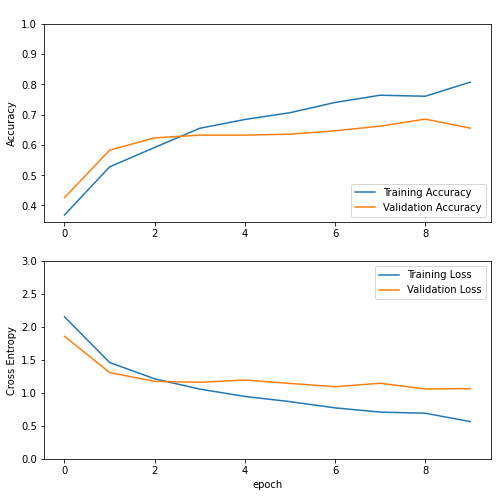

In [10]:
acc = history_base.history['accuracy']
val_acc = history_base.history['val_accuracy']

loss = history_base.history['loss']
val_loss = history_base.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy',fontdict = {'fontsize': '14',
                              'color': 'white'})

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')


plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 3.0])
plt.title('Training and Validation Loss',fontdict = {'fontsize': '14',
                              'color': 'white'})
plt.xlabel('epoch')
plt.show()

In [11]:
result = model3.evaluate(test)
print(result)

16/16 [==============================] - 121s 3s/step - loss: 1.0711 - accuracy: 0.6577
[1.0710813999176025, 0.6576763391494751]


In [12]:
list_of_paths = ['/content/drive/MyDrive/colab/keras/brain_tumor_dataset/Testing/14/161953.025.K.chr14.1invert_pad.jpg',
          '/content/drive/MyDrive/colab/keras/brain_tumor_dataset/Testing/16/161963.001.K.chr16.1invert_pad.jpg',
          '/content/drive/MyDrive/colab/keras/brain_tumor_dataset/Testing/2/173451.026.K.chr2.1invert_pad.jpg',
          '/content/drive/MyDrive/colab/keras/brain_tumor_dataset/Testing/X/161988.121.K.chr23.1invert_pad.jpg',
          '/content/drive/MyDrive/colab/keras/brain_tumor_dataset/Testing/Y/S152055.004.K.chry.1invert_pad.jpg']
test_tumor(list_of_paths,model3)

This image most likely belongs to 14 with a 93.54 percent confidence.
This image most likely belongs to 16 with a 99.05 percent confidence.
This image most likely belongs to 8 with a 39.77 percent confidence.
This image most likely belongs to X with a 85.57 percent confidence.
This image most likely belongs to 18 with a 33.10 percent confidence.


## Fine Tuning the model



In [13]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 80

#Attempting to fine tune more layers
more_layer = 50



#Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  175


In [14]:
model3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              metrics=['accuracy'])
model3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0     

In [15]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model3.fit(train,
                         epochs=total_epochs,
                         initial_epoch=history_base.epoch[-1],
                         validation_data=val)

Epoch 10/40
85/85 [==============================] - 24s 230ms/step - loss: 2.1192 - accuracy: 0.4963 - val_loss: 0.6519 - val_accuracy: 0.7826
Epoch 11/40
85/85 [==============================] - 19s 221ms/step - loss: 0.5698 - accuracy: 0.8220 - val_loss: 0.6382 - val_accuracy: 0.7925
Epoch 12/40
85/85 [==============================] - 20s 223ms/step - loss: 0.3633 - accuracy: 0.8841 - val_loss: 0.4479 - val_accuracy: 0.8620
Epoch 13/40
85/85 [==============================] - 20s 226ms/step - loss: 0.2096 - accuracy: 0.9291 - val_loss: 0.5283 - val_accuracy: 0.8488
Epoch 14/40
85/85 [==============================] - 20s 227ms/step - loss: 0.1769 - accuracy: 0.9499 - val_loss: 0.5277 - val_accuracy: 0.8543
Epoch 15/40
85/85 [==============================] - 20s 229ms/step - loss: 0.1222 - accuracy: 0.9606 - val_loss: 0.5037 - val_accuracy: 0.8488
Epoch 16/40
85/85 [==============================] - 20s 230ms/step - loss: 0.0960 - accuracy: 0.9695 - val_loss: 0.4264 - val_accuracy:

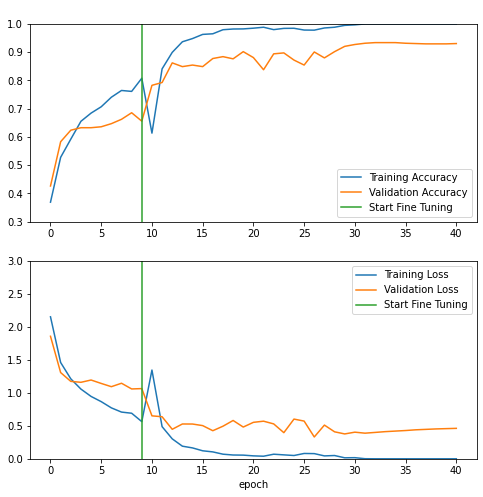

In [16]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.3, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy',fontdict = {'fontsize': '14',
                              'color': 'white'})

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 3.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss',fontdict = {'fontsize': '14',
                              'color': 'white'})
plt.xlabel('epoch')
plt.show()

In [17]:
loss, accuracy = model3.evaluate(test)
print('Test accuracy :', accuracy)

16/16 [==============================] - 2s 91ms/step - loss: 0.3525 - accuracy: 0.9274
Test accuracy : 0.9273858666419983


In [19]:
list_of_paths = ['/content/drive/MyDrive/colab/keras/brain_tumor_dataset/Testing/14/161953.025.K.chr14.1invert_pad.jpg',
          '/content/drive/MyDrive/colab/keras/brain_tumor_dataset/Testing/16/161963.001.K.chr16.1invert_pad.jpg',
          '/content/drive/MyDrive/colab/keras/brain_tumor_dataset/Testing/2/173451.026.K.chr2.1invert_pad.jpg',
          '/content/drive/MyDrive/colab/keras/brain_tumor_dataset/Testing/X/161988.121.K.chr23.1invert_pad.jpg',
          '/content/drive/MyDrive/colab/keras/brain_tumor_dataset/Testing/Y/S152055.004.K.chry.1invert_pad.jpg']
test_tumor(list_of_paths,model3)

This image most likely belongs to 14 with a 99.67 percent confidence.
This image most likely belongs to 16 with a 100.00 percent confidence.
This image most likely belongs to 2 with a 99.99 percent confidence.
This image most likely belongs to X with a 100.00 percent confidence.
This image most likely belongs to 18 with a 92.68 percent confidence.


prediction_label_comparison is defined [here](https://www.kaggle.com/alexmas0n/brain-tumor-classification/output#compare)

In [20]:
labels_entire = []
pred_entire = []
for image_batch,label_batch in test.as_numpy_iterator():
    prediction = model3.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(prediction).numpy()

    n = 0
    predict = []
    while n<=(predictions.shape[0]-24):
        pred = np.argmax(predictions[n:n+24]) #Returns the index of the largest element in the selected subarray
        n+=24
        pred_entire.append(pred)
    for el in label_batch:
        labels_entire.append(el)
pred_entire = np.array(pred_entire)
labels_entire = np.array(labels_entire)
print(pred_entire)
print(labels_entire)

[14  6 11 20  4 13  6 20  8 12  6  8  3 21  2 14  9 12 10  6 13 19  3  8
  3 19 15  6  2 17 11 15 20 15  7  2 17 12 20 17  9 16 18 17  3 14  7  1
  7 11 11  1 17 14  6 11 16 12 18  5 22 14 12  9 19 19 20 16 10  3 11 10
  2  8 15 11 12 11 13  7 14 15  2 19 16 13  7 10 13 13  5 16 17  1  1 13
  4  0  3 10 21  1 19 13  7 19  5 16  5 22 10 14 19 13 20  4 22  1 23 12
  0 20 11 17  5 19 13 17 13  6 14 16  1 21 21  0  5 10 16 22 19  4  8  3
 10 15 11  6 10 22 19 10 15  5  9 18  2 11 19 15 15  4  0  9 11 21 15  4
 19  0  5  0 18  1  7  7  1  8 16  2 18  8 11 17  1  8  9  4  6 18 17 11
  4  6  6 13  1  5  2 20 11 14  3  2  1 16  3  9 16 18 15 20  6 19  0 22
  0 21  4  7 10  6  3 21  2  9 13  5  9 13 20  7  3 19  8  8 21 12 20 15
  5 16 11  0 20  9 10  5 17  0 20  1 20  1  8  8 16 19  4 17  9 14  7 14
  4  9 11  9 21 22  0 14  6  6 10  4  0 16  3  2  2  3 20 11 15 18 15  9
  2  0  2 12  1 14  5 13  2 18 16  5 21  7 15  3  7 16  1 14 14  3  9  9
 14  7  7 17 18 22 20  8  2 22  2  8  4 18 17  6  4

In [21]:
labels_entire.shape

(482,)

In [22]:
pred_entire.shape

(482,)

In [23]:
print(classification_report(labels_entire, pred_entire, target_names=classes))

              precision    recall  f1-score   support

           1       0.95      0.95      0.95        20
          10       0.79      0.90      0.84        21
          11       0.87      0.95      0.91        21
          12       1.00      0.95      0.98        21
          13       1.00      0.95      0.98        21
          14       0.91      0.95      0.93        21
          15       0.90      0.86      0.88        21
          16       1.00      0.95      0.98        21
          17       0.95      0.86      0.90        21
          18       0.83      0.95      0.89        21
          19       0.91      0.95      0.93        21
           2       0.84      1.00      0.91        21
          20       0.94      0.76      0.84        21
          21       0.95      0.90      0.93        21
          22       0.77      0.95      0.85        21
           3       1.00      1.00      1.00        21
           4       0.90      0.90      0.90        21
           5       0.95    

# Using k-fold cross validation

### Reference article for the k-fold cross validation: [Link](https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538)
### Building a .csv file for the images along with their labels: [Reference](https://datascience.stackexchange.com/questions/49094/how-to-transform-a-folder-of-images-into-csv-file)

In [24]:
path_data

PosixPath('/content/drive/MyDrive/colab/keras/brain_tumor_dataset/Training')

In [25]:
label_names = os.listdir(path_data)
label_names

['12',
 '11',
 '1',
 '10',
 '13',
 '14',
 '2',
 '17',
 '20',
 '18',
 '3',
 '15',
 '21',
 '22',
 '19',
 '16',
 'X',
 '8',
 '7',
 '9',
 '6',
 '4',
 'Y',
 '5']

### Functions csv_builder() and cross_validation() have been defined in the [helper functions](#helper)

In [26]:
final_csv = csv_builder(path_data,label_names)
final_csv

,images,labels
0,/content/drive/MyDrive/colab/keras/brain_tumor...,12
1,/content/drive/MyDrive/colab/keras/brain_tumor...,12
2,/content/drive/MyDrive/colab/keras/brain_tumor...,12
3,/content/drive/MyDrive/colab/keras/brain_tumor...,12
4,/content/drive/MyDrive/colab/keras/brain_tumor...,12
...,...,...
3621,/content/drive/MyDrive/colab/keras/brain_tumor...,5
3622,/content/drive/MyDrive/colab/keras/brain_tumor...,5
3623,/content/drive/MyDrive/colab/keras/brain_tumor...,5
3624,/content/drive/MyDrive/colab/keras/brain_tumor...,5


In [27]:
final_csv.to_csv('files_path.csv', header=None)

path_of_csv = './files_path.csv'

test_csv = csv_builder(path_test,label_names)
test_csv

,images,labels
0,/content/drive/MyDrive/colab/keras/brain_tumor...,12
1,/content/drive/MyDrive/colab/keras/brain_tumor...,12
2,/content/drive/MyDrive/colab/keras/brain_tumor...,12
3,/content/drive/MyDrive/colab/keras/brain_tumor...,12
4,/content/drive/MyDrive/colab/keras/brain_tumor...,12
...,...,...
477,/content/drive/MyDrive/colab/keras/brain_tumor...,5
478,/content/drive/MyDrive/colab/keras/brain_tumor...,5
479,/content/drive/MyDrive/colab/keras/brain_tumor...,5
480,/content/drive/MyDrive/colab/keras/brain_tumor...,5


In [28]:
test_csv = test_csv.sample(frac=1)
test_csv

,images,labels
384,/content/drive/MyDrive/colab/keras/brain_tumor...,7
418,/content/drive/MyDrive/colab/keras/brain_tumor...,6
204,/content/drive/MyDrive/colab/keras/brain_tumor...,18
67,/content/drive/MyDrive/colab/keras/brain_tumor...,10
46,/content/drive/MyDrive/colab/keras/brain_tumor...,1
...,...,...
167,/content/drive/MyDrive/colab/keras/brain_tumor...,20
232,/content/drive/MyDrive/colab/keras/brain_tumor...,15
348,/content/drive/MyDrive/colab/keras/brain_tumor...,X
189,/content/drive/MyDrive/colab/keras/brain_tumor...,18


### Defining number of folds

In [29]:
k = 5

### Now this csv file can be used to create a kfold split in the training data

## Cross Validation on Third Model

In [30]:
num_classes = 24
model3 = tf.keras.Sequential([normalization_layer,
                                  conv_layer_32,
                                  max_pool,
                                  #layers.MaxPooling2D(pool_size=(2,2)),
                                  conv_layer_32,
                                  max_pool,
                                  #layers.MaxPooling2D(pool_size=(2,2)),
                                  layers.Flatten(),
                                  layers.Dense(128, activation='relu'),
                                  #layers.Dropout(0.25),
                                  layers.Dense(num_classes,activation='softmax')
                                 ])
model3.compile(optimizer='adam',
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

loss,acc,model3 = cross_validation(k,final_csv,test_csv,img_width,img_height,model3)
print(loss,acc)

Performing cross validation...
Found 482 validated image filenames belonging to 24 classes.
Found 2900 validated image filenames belonging to 24 classes.
Found 726 validated image filenames belonging to 24 classes.
16/16 [==============================] - 1s 67ms/step - loss: 1.4074 - accuracy: 0.5000
Found 2901 validated image filenames belonging to 24 classes.
Found 725 validated image filenames belonging to 24 classes.
16/16 [==============================] - 1s 62ms/step - loss: 0.8736 - accuracy: 0.7116
Found 2901 validated image filenames belonging to 24 classes.
Found 725 validated image filenames belonging to 24 classes.
16/16 [==============================] - 1s 63ms/step - loss: 0.7831 - accuracy: 0.7448
Found 2901 validated image filenames belonging to 24 classes.
Found 725 validated image filenames belonging to 24 classes.
16/16 [==============================] - 1s 64ms/step - loss: 0.7235 - accuracy: 0.7863
Found 2901 validated image filenames belonging to 24 classes.
Fo